In [1]:
# add quantkit to path
import sys
from pathlib import Path
d = Path().resolve().parent.parent.parent
sys.path.insert(0, str(d))

In [11]:
import quantkit.bt as bt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

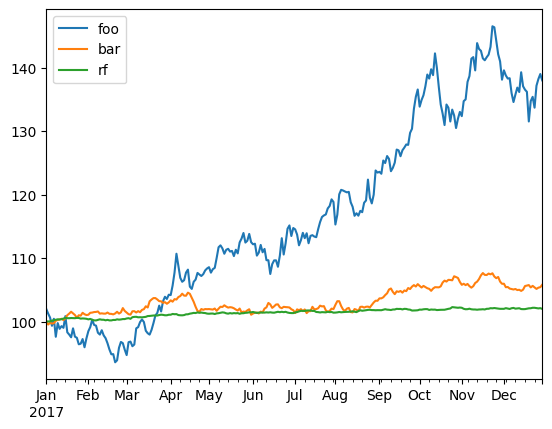

In [12]:
names = ["foo", "bar", "rf"]
dates = pd.date_range(
    start="2017-01-01", end="2017-12-31", freq=pd.tseries.offsets.BDay()
)
n = len(dates)
rdf = pd.DataFrame(np.zeros((n, len(names))), index=dates, columns=names)

np.random.seed(1)
rdf["foo"] = np.random.normal(loc=0.1 / n, scale=0.2 / np.sqrt(n), size=n)
rdf["bar"] = np.random.normal(loc=0.04 / n, scale=0.05 / np.sqrt(n), size=n)
rdf["rf"] = np.random.normal(loc=0.02 / n, scale=0.01 / np.sqrt(n), size=n)

pdf = 100 * np.cumprod(1 + rdf)
pdf.plot();

In [8]:
children = [ bt.Security( name ) for name in pdf.columns ]